In [103]:
import pandas as pd
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, ConfigurationError
import dotenv, re, os
import matplotlib.pyplot as plt

In [3]:
dotenv.load_dotenv()

# Les collections
client       = MongoClient(os.environ["MONGO_URL"])
user         = client['RemiGOAT']['UserData']
message      = client['RemiGOAT']['Message']
Session      = client['RemiGOAT']['Session']
sessionUser  = client['RemiGOAT']['SessionByUser']

In [38]:
def _connect_mongo(host, port, db, username=None, password=None, **kwargs):
    """ A utility for making a connection to MongoDB. """
    try:
        if username and password:
            mongo_uri = f'mongodb://{username}:{password}@{host}:{port}/{db}'
            conn = MongoClient(mongo_uri, **kwargs)
        else:
            conn = MongoClient(host, port, **kwargs)
        conn.admin.command('ping')
        return conn[db]
    except (ConnectionFailure, ConfigurationError) as e:
        print(f"Failed to connect to MongoDB: {e}")
        raise

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, 
               join_collection=None, local_field=None, foreign_field=None, as_field=None, 
               output_collection=None, **kwargs):
    """ Read from MongoDB, optionally join with another collection, and store into DataFrame. """
    try:
        db_conn = _connect_mongo(host=host, port=port, username=username, password=password, db=db, **kwargs)
        if join_collection and local_field and foreign_field and as_field:
            pipeline = [
                {"$match": query},
                {
                    "$lookup": {
                        "from": join_collection,
                        "localField": local_field,
                        "foreignField": foreign_field,
                        "as": as_field
                    }
                }
            ]
            cursor = db_conn[collection].aggregate(pipeline)
        else:
            cursor = db_conn[collection].find(query)
        df = pd.DataFrame(list(cursor))
        if no_id and '_id' in df.columns:
            df.drop('_id', axis=1, inplace=True)
        if output_collection:
            db_conn[output_collection].insert_many(df.to_dict('records'))
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [58]:

dfmessage = read_mongo(
    db='RemiGOAT',
    collection='MessageUser',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
    join_collection='Session',
    local_field='course_id',
    foreign_field='session',
    as_field='session_details',
)
dfmessage

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,type,created_at,updated_at,vote_down_count,vote_up_count,vote_point,vote_count,session_details
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,thread,2014-02-03T07:55:29Z,2014-02-03T07:55:29Z,0,1,1,1,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,comment,2014-02-03T09:20:32Z,2014-02-03T09:20:32Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",thread,2014-02-03T08:04:09Z,2014-02-03T08:04:09Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",comment,2014-02-03T10:46:44Z,2014-02-03T10:46:44Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",comment,2014-02-03T14:12:05Z,2014-02-03T14:12:05Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,thread,2022-06-23T09:27:11Z,2022-06-23T18:56:10Z,0,0,0,0,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ..."
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",comment,2022-06-23T18:56:10Z,2022-06-23T18:56:10Z,0,0,0,0,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ..."
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,thread,2022-06-25T17:37:11Z,2022-06-25T17:37:11Z,0,0,0,0,"[{'_id': 6655d153b56c816808d60efd, 'session': ..."
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,thread,2022-06-26T18:03:34Z,2022-06-26T18:03:34Z,0,0,0,0,"[{'_id': 6655d153b56c816808d60eff, 'session': ..."


In [59]:
dfusers = read_mongo(
    db='RemiGOAT',
    collection='UserData',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
)
dfusers

,username,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp
0,jirasrideslis,58d571786d4d80c00f9c1465,None,,None,None,jirasri.deslis@fun-mooc.fr,None,None,NaN
1,Osiatis_FUN,58d571786d4d80c00f9c1466,Grenoble,FR,m,hs,assistance.at.fun@gmail.com,None,1985,NaN
2,EllaHamonic,58d571786d4d80c00f9c1467,Paris,FR,f,m,ella.hamonic@mines-telecom.fr,"Cadre, sup",1989,NaN
3,DelphineLalire,58d571786d4d80c00f9c1468,None,,f,m,delphine.lalire@mines-telecom.fr,None,1972,NaN
4,baptistegaultier,58d571786d4d80c00f9c1469,None,,None,None,baptiste.gaultier@telecom-bretagne.eu,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
112386,Ronzephir,62d799e873c4e45c2dd685a1,None,None,None,None,None,None,None,NaN
112387,Valerie_Hd,62d799e873c4e45c2dd685a3,None,None,None,None,None,None,None,NaN
112388,lilite5,62d799e873c4e45c2dd685a5,None,None,None,None,None,None,None,NaN
112389,None,NaN,None,None,m,None,None,"Cadre, sup",None,NaN


In [60]:
# Fusionner les deux DataFrames sur la colonne "username"
df_merged = pd.merge(dfmessage, dfusers, on='username', how='inner')

In [61]:
df_merged

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,session_details,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4ea8,None,None,None,None,None,None,None,NaN
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4e5d,None,None,None,None,None,None,None,NaN
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4ea5,None,None,None,None,None,None,None,NaN
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",58ff48ae88d1216b89e59da1,None,None,None,None,None,None,None,NaN
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4e23,None,None,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ...",62b864c95eb901d30ae7fb8a,None,None,None,None,None,None,None,NaN
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ...",58d571866d4d80c00f9c25e7,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,NaN
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,"[{'_id': 6655d153b56c816808d60efd, 'session': ...",62b863255eb901d30ae7f372,None,None,None,None,None,None,None,NaN
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,"[{'_id': 6655d153b56c816808d60eff, 'session': ...",62b864c95eb901d30ae7fb8a,None,None,None,None,None,None,None,NaN


In [62]:
df_merged['session_details']

0         [{'_id': 6655d14eb56c816808d5c898, 'session': ...
1         [{'_id': 6655d14eb56c816808d5c898, 'session': ...
2         [{'_id': 6655d14eb56c816808d5c898, 'session': ...
3         [{'_id': 6655d14eb56c816808d5c898, 'session': ...
4         [{'_id': 6655d14eb56c816808d5c898, 'session': ...
                                ...                        
169608    [{'_id': 6655d14fb56c816808d5d65a, 'session': ...
169609    [{'_id': 6655d14fb56c816808d5d65a, 'session': ...
169610    [{'_id': 6655d153b56c816808d60efd, 'session': ...
169611    [{'_id': 6655d153b56c816808d60eff, 'session': ...
169612    [{'_id': 6655d153b56c816808d60eff, 'session': ...
Name: session_details, Length: 169613, dtype: object

In [63]:
# Extraire les valeurs de chaque dictionnaire dans la liste et créer de nouvelles colonnes avec ces valeurs
for key in df_merged['session_details'][0][0].keys():
    df_merged[key] = df_merged['session_details'].apply(lambda x: x[0][key] if isinstance(x, list) and len(x) > 0 else None)

# Supprimer la colonne "session_details" originale
df_merged.drop(columns=['session_details'], inplace=True)


In [64]:
# Afficher le DataFrame résultant
df_merged

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,country,gender,level_of_education,email,CSP,year_of_birth,csp,_id,session,IsEval
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,None,None,None,None,None,None,NaN,6655d14fb56c816808d5d65a,course-v1:MinesTelecom+04017+session12,False
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,NaN,6655d14fb56c816808d5d65a,course-v1:MinesTelecom+04017+session12,False
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,None,None,None,None,None,None,NaN,6655d153b56c816808d60efd,course-v1:MinesTelecom+04026+session10,False
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,None,None,None,None,None,None,NaN,6655d153b56c816808d60eff,course-v1:MinesTelecom+04021+session12,False


In [65]:
# Filtrer les lignes où la valeur de la colonne "IsEval" est égale à True
df_IsEval = df_merged[df_merged['IsEval'] == True]

df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,country,gender,level_of_education,email,CSP,year_of_birth,csp,_id,session,IsEval
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,FR,m,hs,djuz87@gmail.com,Employé,1968,NaN,6655d075b56c816808d5c4c1,MinesTelecom/04017/session01,True
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963,NaN,6655d075b56c816808d5c4c1,MinesTelecom/04017/session01,True
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,,m,hs,virgile.calvert@imbe.fr,Prof interm,1976,NaN,6655d075b56c816808d5c4c1,MinesTelecom/04017/session01,True
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,FR,m,m,b.gaultier@gmail.com,None,1986,NaN,6655d075b56c816808d5c4c1,MinesTelecom/04017/session01,True
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,,m,hs,None,Retraité,1954,NaN,6655d075b56c816808d5c4c1,MinesTelecom/04017/session01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152352,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,None,None,None,None,None,None,NaN,6655d14db56c816808d5c5ba,course-v1:MinesTelecom+04026+session03,True
154628,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,None,None,None,None,None,None,NaN,6655d14db56c816808d5c5b8,course-v1:MinesTelecom+04021+session05,True
154689,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,None,None,None,None,None,None,NaN,6655d14db56c816808d5c5b8,course-v1:MinesTelecom+04021+session05,True
155833,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,FR,m,hs,None,Employé,1987,NaN,6655d075b56c816808d5c4c3,MinesTelecom/04017S02/session02,True


In [69]:
df_IsEval.columns

Index(['message_id', 'parent_id', 'thread_id', 'thread_type', 'title',
       'context', 'courseware_title', 'course_id', 'username', 'body', 'type',
       'created_at', 'updated_at', 'vote_down_count', 'vote_up_count',
       'vote_point', 'vote_count', 'id', 'city', 'country', 'gender',
       'level_of_education', 'email', 'CSP', 'year_of_birth', 'csp', '_id',
       'session', 'IsEval'],
      dtype='object')

In [70]:
df_IsEval.drop(columns=['session', '_id'], inplace=True)

C:\Users\RED94\AppData\Local\Temp\ipykernel_21176\2108505053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval.drop(columns=['session', '_id'], inplace=True)


In [71]:
df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,IsEval
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,NaN,True
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963,NaN,True
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,None,,m,hs,virgile.calvert@imbe.fr,Prof interm,1976,NaN,True
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,None,FR,m,m,b.gaultier@gmail.com,None,1986,NaN,True
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,None,,m,hs,None,Retraité,1954,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152352,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,None,None,None,None,None,None,None,NaN,True
154628,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,None,None,None,None,None,None,None,NaN,True
154689,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,None,None,None,None,None,None,None,NaN,True
155833,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,Paris,FR,m,hs,None,Employé,1987,NaN,True


In [87]:
# Créer un dictionnaire pour stocker les valeurs correspondantes pour chaque thread_id
thread_id_values = {}

# Parcourir les lignes du DataFrame
for index, row in df_IsEval.iterrows():
    # Si le thread_id n'est pas dans le dictionnaire, l'ajouter avec les valeurs actuelles
    if row['thread_id'] not in thread_id_values:
        thread_id_values[row['thread_id']] = {
            'title': row['title'],
            'context': row['context'],
            'courseware_title': row['courseware_title'],
            'thread_type' : row['thread_type']
        }
    # Si le thread_id est dans le dictionnaire mais a des valeurs manquantes, remplacer NaN par les valeurs existantes
    else:
        if pd.isna(thread_id_values[row['thread_id']]['title']):
            thread_id_values[row['thread_id']]['title'] = row['title']
        if pd.isna(thread_id_values[row['thread_id']]['context']):
            thread_id_values[row['thread_id']]['context'] = row['context']
        if pd.isna(thread_id_values[row['thread_id']]['courseware_title']):
            thread_id_values[row['thread_id']]['courseware_title'] = row['courseware_title']
        if pd.isna(thread_id_values[row['thread_id']]['thread_type']):
            thread_id_values[row['thread_id']]['thread_type'] = row['thread_type']

# Remplacer les valeurs NaN dans le DataFrame original par les valeurs du dictionnaire correspondant au thread_id
df_IsEval['title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['title'] if pd.isna(row['title']) else row['title'], axis=1)
df_IsEval['context'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['context'] if pd.isna(row['context']) else row['context'], axis=1)
df_IsEval['courseware_title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['courseware_title'] if pd.isna(row['courseware_title']) else row['courseware_title'], axis=1)
df_IsEval['thread_type'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['thread_type'] if pd.isna(row['thread_type']) else row['thread_type'], axis=1)

C:\Users\RED94\AppData\Local\Temp\ipykernel_21176\2730770919.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval['title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['title'] if pd.isna(row['title']) else row['title'], axis=1)
C:\Users\RED94\AppData\Local\Temp\ipykernel_21176\2730770919.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval['context'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['context'] if pd.isna(row['context']) else row['conte

In [89]:
df_IsEval = df_IsEval.sort_values(by='thread_id')

In [95]:
# Remplacer les NaN par None
df_IsEval.replace({pd.NA: None}, inplace=True)

In [96]:
df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,IsEval
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,True
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963,None,True
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,None,,m,hs,virgile.calvert@imbe.fr,Prof interm,1976,None,True
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,None,FR,m,m,b.gaultier@gmail.com,None,1986,None,True
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,None,,m,hs,None,Retraité,1954,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152352,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,None,None,None,None,None,None,None,None,True
154628,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,None,None,None,None,None,None,None,None,True
154689,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,None,None,None,None,None,None,None,None,True
155833,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,Paris,FR,m,hs,None,Employé,1987,None,True


In [99]:
# Filtrer les données pour l'username 'Djuz87'
username_data = df_IsEval[df_IsEval['username'] == 'Djuz87']

# Afficher les données pour l'username 'Djuz87'
username_data

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,IsEval
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,True
28736,576270d69b101dc5700000c1,575748b160d73b23e00000c1,575748b160d73b23e00000c1,discussion,Un mini TOM perso,course,None,MinesTelecom/04018/session01,Djuz87,"Bonjour,\n\nJe suis entrain de tester Tom3\n\n...",...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,True
28730,57605aec54ecc04b2f00008c,5760110ec5a34504df000090,575748b160d73b23e00000c1,discussion,Un mini TOM perso,course,None,MinesTelecom/04018/session01,Djuz87,Bonsoir Gerard4\nMerci pour l'info.\nCordialement,...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,True
28740,5762d567bf989a61e4000002,576270d69b101dc5700000c1,575748b160d73b23e00000c1,discussion,Un mini TOM perso,course,None,MinesTelecom/04018/session01,Djuz87,"Bonsoir\n\nJ'ai testé le code, ça me met la mê...",...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,True
28741,5762d729bf989acc24000002,576270d69b101dc5700000c1,575748b160d73b23e00000c1,discussion,Un mini TOM perso,course,None,MinesTelecom/04018/session01,Djuz87,ma version de PHP est:\nVersion PHP courante :...,...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,True
28728,57602924bf989a66e600007c,5760110ec5a34504df000090,575748b160d73b23e00000c1,discussion,Un mini TOM perso,course,None,MinesTelecom/04018/session01,Djuz87,Salut Gerard4\nPeut tu me communiquer le nom l...,...,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,True


In [100]:
# Compter le nombre d'username différents
nombre_username = df_IsEval['username'].nunique()

# Afficher le nombre d'username différents
print("Nombre d'username différents :", nombre_username)

Nombre d'username différents : 4353


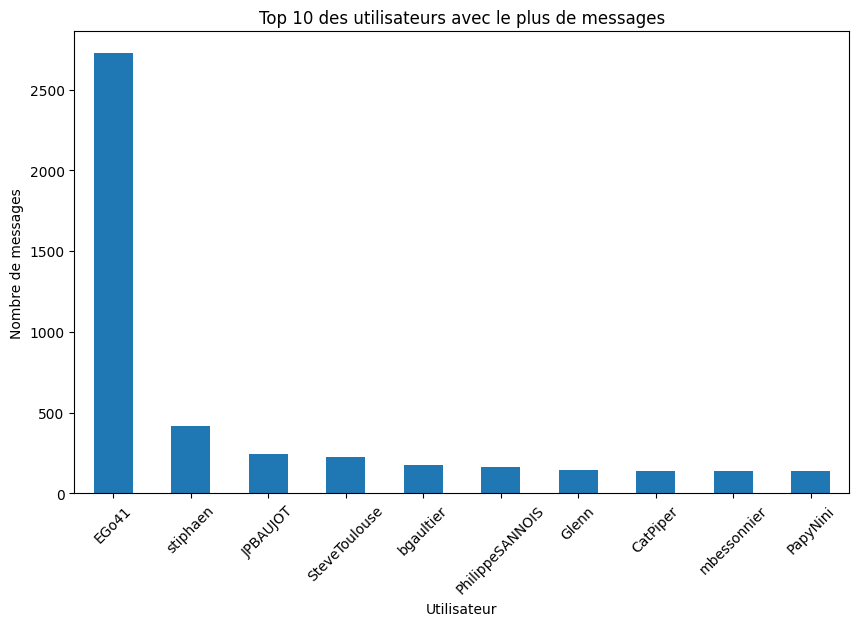

In [105]:
# Grouper par username et compter le nombre de messages, puis trier par ordre décroissant et prendre les 10 premiers
top_10_utilisateurs = df_IsEval['username'].value_counts().head(10)

# Créer le graphique
plt.figure(figsize=(10, 6))
top_10_utilisateurs.plot(kind='bar')
plt.title('Top 10 des utilisateurs avec le plus de messages')
plt.xlabel('Utilisateur')
plt.ylabel('Nombre de messages')
plt.xticks(rotation=45)
plt.show()